<a href="https://colab.research.google.com/github/cocoisland/DS-Sprint-01-Dealing-With-Data/blob/master/LiveClass_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=299.46025581945514, mobile=True), User(purchased=False, time_on_site=157.91934672102977, mobile=True), User(purchased=False, time_on_site=347.4937842763547, mobile=False), User(purchased=False, time_on_site=134.95867838238647, mobile=False), User(purchased=False, time_on_site=6.083706023000959, mobile=True), User(purchased=False, time_on_site=253.0947908615351, mobile=True), User(purchased=False, time_on_site=257.96717383595137, mobile=False), User(purchased=False, time_on_site=50.39491195790989, mobile=False), User(purchased=False, time_on_site=14.457721821344476, mobile=True), User(purchased=False, time_on_site=71.59453217188525, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,299.460256,True
1,False,157.919347,True
2,False,347.493784,False
3,False,134.958678,False
4,False,6.083706,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.288335357601311,5.668372284464373,5.726888909133093,5.906933566104325,6.083706023000959,6.184645001827223,6.261829782306979,8.21550091702441,8.585126581349119,8.656925811182454,...,561.1667185928544,561.2285191229038,567.1269228055639,570.989046996401,571.530282060022,572.1649760161758,585.2584630999561,589.0763109772122,592.204896907007,598.9103353043214
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.695, 124.013]","(124.013, 242.737]","(242.737, 361.462]","(361.462, 480.186]","(480.186, 598.91]"
purchased,,,,,
False,286,285,179,45,31
True,58,64,40,7,5


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.695, 124.013]","(124.013, 242.737]","(242.737, 361.462]","(361.462, 480.186]","(480.186, 598.91]"
purchased,,,,,
False,0.831395,0.816619,0.817352,0.865385,0.861111
True,0.168605,0.183381,0.182648,0.134615,0.138889


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.892,0.804
True,0.108,0.196


In [0]:
# More on binning
pd.cut(user_data['time_on_site'], 5)

0      (242.737, 361.462]
1      (124.013, 242.737]
2      (242.737, 361.462]
3      (124.013, 242.737]
4        (4.695, 124.013]
5      (242.737, 361.462]
6      (242.737, 361.462]
7        (4.695, 124.013]
8        (4.695, 124.013]
9        (4.695, 124.013]
10     (124.013, 242.737]
11     (124.013, 242.737]
12     (124.013, 242.737]
13     (124.013, 242.737]
14     (242.737, 361.462]
15       (4.695, 124.013]
16     (242.737, 361.462]
17     (124.013, 242.737]
18     (242.737, 361.462]
19     (361.462, 480.186]
20       (4.695, 124.013]
21     (242.737, 361.462]
22     (124.013, 242.737]
23       (4.695, 124.013]
24       (4.695, 124.013]
25     (242.737, 361.462]
26     (124.013, 242.737]
27     (242.737, 361.462]
28     (124.013, 242.737]
29       (4.695, 124.013]
              ...        
970    (124.013, 242.737]
971     (480.186, 598.91]
972    (124.013, 242.737]
973    (124.013, 242.737]
974    (242.737, 361.462]
975    (124.013, 242.737]
976    (124.013, 242.737]
977    (361.

In [0]:
help(pd.cut)

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
    Return indices of half-open bins to which each value of `x` belongs.
    
    Parameters
    ----------
    x : array-like
        Input array to be binned. It has to be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        If `bins` is an int, it defines the number of equal-width bins in the
        range of `x`. However, in this case, the range of `x` is extended
        by .1% on each side to include the min or max values of `x`. If
        `bins` is a sequence it defines the bin edges allowing for
        non-uniform bin width. No extension of the range of `x` is done in
        this case.
    right : bool, optional
        Indicates whether the bins include the rightmost edge or not. If
        right == True (the default), then the bins [1,2,3,4] indicate
        (1,2], (2,3], (3,4].
    labels : array or boole

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
            normalize='columns')

mobile                        False     True 
purchased time_on_site                       
False     (4.695, 124.013]    0.164  0.326667
          (124.013, 242.737]  0.212  0.309333
          (242.737, 361.462]  0.212  0.168000
          (361.462, 480.186]  0.180  0.000000
          (480.186, 598.91]   0.124  0.000000
True      (4.695, 124.013]    0.016  0.072000
          (124.013, 242.737]  0.016  0.080000
          (242.737, 361.462]  0.028  0.044000
          (361.462, 480.186]  0.028  0.000000
          (480.186, 598.91]   0.020  0.000000

In [0]:
help(user_data.plot.bar)

Help on method bar in module pandas.plotting._core:

bar(x=None, y=None, **kwds) method of pandas.plotting._core.FramePlotMethods instance
    Vertical bar plot
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    x, y : label or position, optional
        Coordinates for each point.
    **kwds : optional
        Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.
    
    Returns
    -------
    axes : matplotlib.AxesSubplot or np.array of them



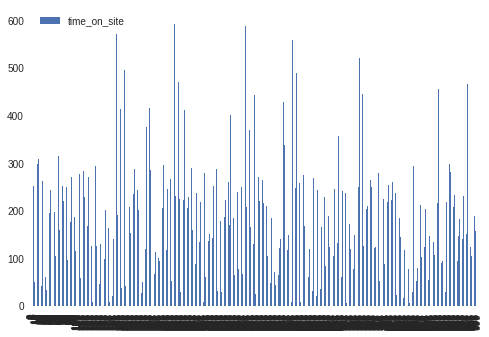

In [0]:
user_data.plot.bar()

In [0]:
# So we have a working barchart method
# Does it just expand our crosstab?
ct = pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
                 normalize='columns')
ct

mobile                        False     True 
purchased time_on_site                       
False     (4.695, 124.013]    0.164  0.326667
          (124.013, 242.737]  0.212  0.309333
          (242.737, 361.462]  0.212  0.168000
          (361.462, 480.186]  0.180  0.000000
          (480.186, 598.91]   0.124  0.000000
True      (4.695, 124.013]    0.016  0.072000
          (124.013, 242.737]  0.016  0.080000
          (242.737, 361.462]  0.028  0.044000
          (361.462, 480.186]  0.028  0.000000
          (480.186, 598.91]   0.020  0.000000

In [0]:
dir(ct)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',


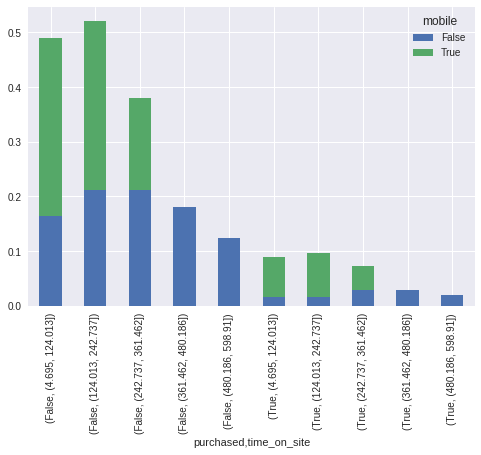

In [0]:
ct.plot(kind='bar', stacked=True)

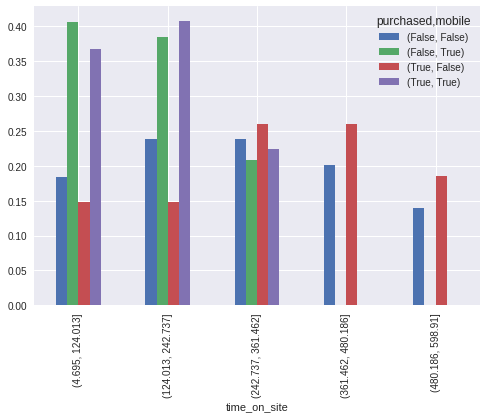

In [0]:
# Courtesy of A
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            normalize='columns').plot(kind = 'bar', stacked = False);

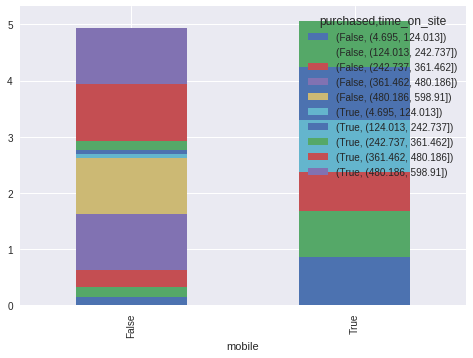

In [0]:
# Starting point for mobile/desktop stacked barcharts
# Probably want to redo with fewer time-bins
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            normalize='columns').plot(kind = 'bar', stacked = True);

In [0]:
'scatter' in dir(ct.plot)

True

In [0]:
grouped_data = user_data['mobile'].groupby(user_data['purchased'])

In [0]:
dir(grouped_data)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_doc',
 '_aggregate',
 '_aggregate_multiple_funcs',
 '_aggregate_named',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_builtin_table',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_def_str',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_get_index',
 '_get_indices',
 '_gotitem',
 '_group_selection',
 '_index_with_as_index',
 '_internal_names',
 '_internal_

In [0]:
# TODO continue exploring grouped_data, grouped_data.plot, etc.

In [0]:
[x for x in dir(ct) if 'add' in x]  # Courtesy of Ryan Herr

['__add__',
 '__iadd__',
 '__radd__',
 '_add_numeric_operations',
 '_add_series_only_operations',
 '_add_series_or_dataframe_operations',
 '_dir_additions',
 'add',
 'add_prefix',
 'add_suffix',
 'radd']

In [0]:
ct_props = dir(ct)
'add' in ct_props

True

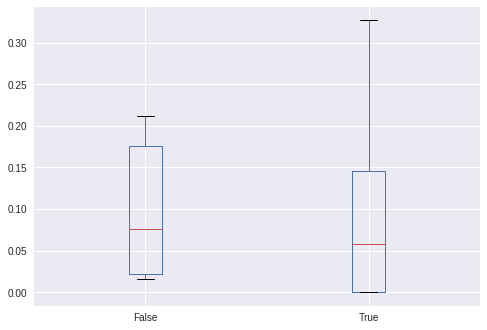

In [0]:
ct.boxplot()

In [0]:
!apt install r-base

  Using cached https://files.pythonhosted.org/packages/f1/98/c7652cc9d7fc0afce74d2c30a52b9c9ac391713a63d037e4ab8feb56c530/rpy2-2.9.4.tar.gz
    Complete output from command python setup.py egg_info:
    Error: Tried to guess R's HOME but no command 'R' in the PATH.
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-install-qeuxylwp/rpy2/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  autoconf automake autopoint autotools-dev bsdmainutils bzip2-doc cdbs
  debhelper dh-autoreconf dh-strip-nondeterminism dh-translations file
  fontconfig gettext gettext-base groff-base intltool intltool-debian jq
  libarchive-cpio-perl libarchive-zip-perl libauthen-sasl-perl libbz2-dev
  libcairo2 libcroco3 libdata-dump-perl libdatrie1 libdrm-amdgpu1
  libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libencode-locale-perl
  libfile-based

In [0]:
!R --version

R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



In [0]:
!pip install rpy2

  Using cached https://files.pythonhosted.org/packages/f1/98/c7652cc9d7fc0afce74d2c30a52b9c9ac391713a63d037e4ab8feb56c530/rpy2-2.9.4.tar.gz
  Running setup.py bdist_wheel for rpy2 ... - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/10/e7/1b/e1d57fc4ad3d6d650ea93b5ed053cd1d7d37ac0be85d864b0c
Successfully built rpy2


In [0]:
# Download the data
data_url = 'https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda'

!wget $data_url
!ls

--2018-11-08 18:09:21--  https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda [following]
--2018-11-08 18:09:21--  https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7090 (6.9K) [application/octet-stream]
Saving to: ‘simpsons_paradox.rda’

simpsons_paradox.rd 100%[===================>]   6.92K  --.-KB/s    in 0s      

2018-11-08 18:09:21 (61.3 MB/s) - ‘simpsons_paradox.rda

In [0]:
!pip install tzlocal

  Running setup.py bdist_wheel for tzlocal ... - \ done
  Stored in directory: /root/.cache/pip/wheels/15/ae/df/a67bf1ed84e9bf230187d36d8dcfd30072bea0236cb059ed91
Successfully built tzlocal


In [0]:
# Trying to load R data in Python
# https://itsalocke.com/datasaurus/reference/simpsons_paradox
# https://stackoverflow.com/questions/40160149/reading-rda-file-in-python-as-a-pandas-data-frame#40161783

import rpy2.robjects as robjects
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

# load your file
robjects.r['load']('simpsons_paradox.rda')

# use the default conversion rules to which the pandas conversion
# is added
with localconverter(default_converter + pandas2ri.converter) as cv:
    df = robjects.r["data"]

matrix = robjects.r['data']

matrix

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f761d216b48 / R:0x5cae548>

In [0]:
thing = df()

In [0]:
for item in thing.items():
  print(item)

('title', R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f761cf2ac88 / R:0x5cd10f8>
['Data sets'])
('header', rpy2.rinterface.NULL)
('results', R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f761cf2a948 / R:0x48e4000>
['datasets', 'datasets', 'datasets', 'datasets', ..., 'Populati..., "Topograp..., 'The Numb..., 'Average ...])
('footer', R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f761cf2ad48 / R:0x57d4d18>
['Use ‘data(package = .packages(all.available = TR...])


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)